# Analysis on user timelines
To see how these user-timelines were downloaded, see:

`sm_w2v.__main__.run_user_timeline_download()`

Data were downloaded to:

`data/user_timeline_tweets.json`

In [18]:
# load and concatenate tweet timeline-documents
import json

train = False

user_timelines = dict()
with open('../data/user_timeline_tweets.json') as f_in:
    for l in f_in:
        try:
            twt = json.loads(l)
        except:
            continue
        user_id_str = twt['user']['id_str']
        if user_id_str in user_timelines:
            user_timelines[user_id_str] = user_timelines[user_id_str] + ' ' + twt['text']
        else:
            user_timelines[user_id_str] = twt['text']

# clean/preprocess text

In [19]:
from gensim.parsing.preprocessing import STOPWORDS
import re


STOPWORDS_ = ['rt', '', 'httpst', 'amp', 'https\'']

def clean_text(text):
    clean = re.sub(r'http.*$', '', text)
    clean = re.sub(r'[^a-zA-Z\s]', '', clean)

    clean = clean.lower()
    word_list = clean.split()
    word_list = [w for w in word_list if (w not in STOPWORDS_ and w not in STOPWORDS)]

    return word_list

user_clean_timelines = dict()
for user_id_str in user_timelines.keys():
    user_clean_timelines[user_id_str] = clean_text(user_timelines[user_id_str])

# LDA topic modeling on timeline documents

In [20]:
from gensim.models.ldamodel import LdaModel
from gensim.models import TfidfModel
from gensim import corpora


user_timelines_keys = []
texts = []
for k, v in user_clean_timelines.items():
    user_timelines_keys.append(k)
    texts.append(v)

# filter out users with less than 200 words in the tweets in their timelines
long_timelines = [t for t in texts if len(t) > 200]
dictionary = corpora.Dictionary(long_timelines)
dictionary.filter_extremes(no_below=10, no_above=0.3, keep_n=100000)
corpus = [dictionary.doc2bow(text) for text in long_timelines]
tfidf = TfidfModel(corpus)
corpus = tfidf[corpus]
corpus = corpus[0:500]
print('number of user-timelines:', len(corpus))

if train:
    model = LdaModel(corpus, id2word=dictionary, num_topics=10, iterations=50, passes=10)
    model.save('../models/lda_user_timelines.model')

else:
    model = LdaModel.load('../models/lda_user_timelines.model')

number of user-timelines: 500


In [21]:
# idenitify topics of interest
model.print_topics(20)

[(0,
  '0.002*que + 0.001*por + 0.001*para + 0.001*milan + 0.001*een + 0.001*albany + 0.001*es + 0.000*het + 0.000*del + 0.000*bir'),
 (1,
  '0.001*yg + 0.001*ini + 0.001*yang + 0.000*aku + 0.000*breakingbad + 0.000*untuk + 0.000*akan + 0.000*mtvstars + 0.000*dari + 0.000*kita'),
 (2,
  '0.001*lmao + 0.001*nigeria + 0.000*syria + 0.000*nigga + 0.000*kca + 0.000*arsenal + 0.000*eau + 0.000*prevention + 0.000*cannabis + 0.000*bitcoin'),
 (3,
  '0.000*ntv + 0.000*inspiringthinkn + 0.000*ktnkenya + 0.000*haber + 0.000*tuscany + 0.000*sunburn + 0.000*lisavanderpump + 0.000*factsguide + 0.000*autocorrects + 0.000*boogie'),
 (4,
  '0.003*gurmeetramrahim + 0.001*ang + 0.001*ng + 0.001*ji + 0.001*ako + 0.001*asmsg + 0.001*foamed + 0.001*messagesofmsg + 0.001*telugu + 0.001*pocus'),
 (5,
  '0.001*remedies + 0.000*tw + 0.000*mx + 0.000*rid + 0.000*momlife + 0.000*disclosure + 0.000*php + 0.000*lefty + 0.000*catholic + 0.000*equals'),
 (6,
  '0.000*flipboard + 0.000*mongolia + 0.000*gettingtozero 

In [22]:
# show users vs. features (topics)
features = dict()

for i, doc in enumerate(corpus):
    features[user_timelines_keys[i]] = model.get_document_topics(doc, minimum_probability=None)


In [23]:
# do time-plot of features for a specific user (topics) vs. time
import pandas as pd
import numpy as np

columns = ['topic0', 'topic1', 'topic2', 'topic3', 'topic4',
           'topic5', 'topic6', 'topic7', 'topic8', 'topic9']
index = user_timelines_keys
df = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns=columns, index=index)

for doc_ind, user_doc in enumerate(features.values()):
    for topic in user_doc:
        df.iloc[doc_ind, topic[0]] = topic[1]

In [24]:
df.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
414373026,0.000000,0.000000,0.704495,0.000000,0.000000,0.000000,0.000000,0.000000,0.240132,0.000000
2217051040,0.011166,0.011161,0.437829,0.011161,0.011164,0.011161,0.011172,0.011161,0.472723,0.011303
27247044,0.020392,0.020395,0.297891,0.020399,0.020392,0.362776,0.020392,0.020392,0.196580,0.020393
1017001722,0.000000,0.000000,0.104076,0.000000,0.000000,0.000000,0.000000,0.000000,0.823613,0.000000
4848682894,0.000000,0.000000,0.649604,0.000000,0.000000,0.000000,0.000000,0.000000,0.184675,0.135123


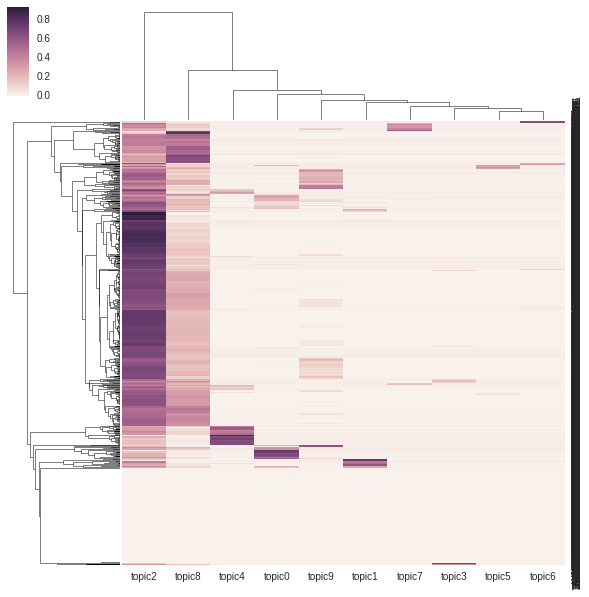

In [27]:
import seaborn as sns
%matplotlib inline

figure = sns.clustermap(df)
figure.savefig('user_timeline_clustermap.pdf', format='pdf')